<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Lab3_2_Multimodal_LLM_for_Surgical_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://drive.google.com/uc?id=1KCWZlI8tS6fyCkbOI3pOUiahyZGjAzug"/ width=400px></center>

#Lab 3.2: Multimodal LLM for Surgical AI

This hands-on tutorial is designed to build a multimodal Large Language Model (LLM) for Surgical Visual Question Answering (VQA). It leverages EndoVis-18-VQA, the first and most widely adopted surgical VQA dataset, and enables multimodal vision-language processing by employing LoRA-based fine-tuning on GPT2, the only fully open-source GPT model available.

###Download and Prepare Dataset
Endovis18-VQA Dataset: https://arxiv.org/pdf/2206.11053

<img src="https://drive.google.com/uc?id=1bm_gfzTFH_u1yd7uRNtJUWrCjTXlZio7" width="500px">

In [1]:
#Download Dataset
!gdown --id 1FoAEY_u0PTAlrscjEifi2om15A83wL78

# Unzipping the VQA EndoVis18 Dataset
!unzip -q EndoVis-18-VQA.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1FoAEY_u0PTAlrscjEifi2om15A83wL78
From (redirected): https://drive.google.com/uc?id=1FoAEY_u0PTAlrscjEifi2om15A83wL78&confirm=t&uuid=d522f06d-48e5-4ce6-9810-193ed1cf9fee
To: /content/EndoVis-18-VQA.zip
100% 2.71G/2.71G [00:46<00:00, 57.7MB/s]


Install necessary packages

In [11]:
!pip install -q -U evaluate bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00


### Dataloader

Total files: 1560 | Total question: 10574
Total files: 447 | Total question: 3216
Sample size: Training: 10574 validation: 3216
question: what organ is being operated?
Answer (label): organ being operated is kidney


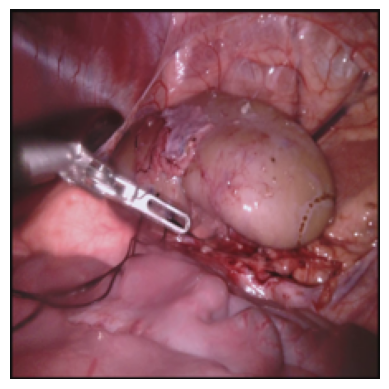

In [1]:
import os
import glob

from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pathlib import Path
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt

class EndoVis18VQA(Dataset):
    def __init__(self, seq, folder_head, folder_tail):

        self.transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),  # input image size
            transforms.ToTensor(),
        ])

        # files, question and answers
        filenames = []
        for curr_seq in seq:
            filenames = filenames + glob.glob(folder_head + str(curr_seq) + folder_tail)
        self.vqas = []
        for file in filenames:
            file_data = open(file, "r")
            lines = [line.strip("\n") for line in file_data if line != "\n"]
            file_data.close()
            for line in lines:
                self.vqas.append([file, line])
        print('Total files: %d | Total question: %.d' % (len(filenames), len(self.vqas)))

    def __len__(self):
        return len(self.vqas)

    def __getitem__(self, idx):
        qa_full_path = Path(self.vqas[idx][0])
        seq_path = qa_full_path.parents[2]
        file_name = self.vqas[idx][0].split('/')[-1]  # / in linux and \\ in windows

        # img
        img_loc = os.path.join(seq_path, 'left_fr', file_name.split('_')[0] + '.png')
        raw_image = Image.open(img_loc).convert('RGB')
        img = self.transform(raw_image)

        # question and answer
        question, answer = self.vqas[idx][1].split('|')

        return img_loc, img, question, answer

# Checking dataset and sample size
train_seq = [2, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15]
val_seq = [1, 5, 16]
folder_head = 'EndoVis-18-VQA/seq_'
folder_tail = '/vqa/Sentence/*.txt'

# dataloader
train_dataset = EndoVis18VQA(train_seq, folder_head, folder_tail)
val_dataset = EndoVis18VQA(val_seq, folder_head, folder_tail)
print('Sample size: Training:', len(train_dataset), 'validation:', len(val_dataset))

img_loc, img, question, answer = train_dataset[0]
plt.axis('OFF')
plt.imshow(img.permute(1,2,0))
print('question:', question)
print('Answer (label):', answer)

### Model


This implementation presents a simplified version of the model described in the paper: https://arxiv.org/pdf/2502.14149?

<img src="https://drive.google.com/uc?id=1Jdi0pj1UnB-3TTU-I5W7kxzSZOhqsGKG" width="800px">

<img src="https://learnopencv.com/wp-content/uploads/2024/02/Figure6_lora_animated.gif" width="300px">


In [2]:
import math
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import ViTModel, BlipTextModel
from peft import get_peft_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PitVQAGen(nn.Module):
    def __init__(self, peft_config=None):
        super(PitVQAGen, self).__init__()

        # visual encoder
        model_name = "google/vit-base-patch16-224-in21k"
        self.visual_encoder = ViTModel.from_pretrained(model_name)

        # tokenizer
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token  # end of string

        # text encoder
        self.text_encoder = BlipTextModel.from_pretrained("Salesforce/blip-vqa-base")

        # copy weights
        original_weights = self.text_encoder.embeddings.word_embeddings.weight.data
        new_vocab_size = len(self.tokenizer)
        embedding_dim = self.text_encoder.embeddings.word_embeddings.embedding_dim
        new_embeddings = nn.Embedding(new_vocab_size, embedding_dim)
        original_vocab_size = original_weights.shape[0]
        new_embeddings.weight.data[:original_vocab_size] = original_weights
        self.text_encoder.embeddings.word_embeddings = new_embeddings

        # gpt2 decoder
        gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt = get_peft_model(gpt, peft_config)
        self.gpt.print_trainable_parameters()  # Verify trainable MoRA parameters

    def forward(self, image, qa_inputs_ids, qa_att_mask):
        # visual encoder
        image = image.to(device)
        image_embeds = self.visual_encoder(image).last_hidden_state
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image.device)

        # multimodal encoder
        text_output = self.text_encoder(input_ids=qa_inputs_ids,
                                        attention_mask=qa_att_mask,
                                        encoder_hidden_states=image_embeds,
                                        encoder_attention_mask=image_atts,
                                        return_dict=True)
        text_embeds = text_output.last_hidden_state

        # text decoder
        gpt_output = self.gpt(inputs_embeds=text_embeds,
                              encoder_attention_mask=qa_att_mask)
        return gpt_output.logits

### Main

In [3]:
import os
import torch
import argparse
import torch.utils.data
import numpy as np
import random

from torch import nn
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer

import evaluate
from nltk.translate.bleu_score import corpus_bleu
from peft import  TaskType, LoraConfig

import warnings
warnings.filterwarnings('ignore')

def adjust_learning_rate(optimizer, shrink_factor):
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

def train(args, train_dataloader, model, criterion, optimizer, epoch, tokenizer, device):
    model.train()
    total_loss = []

    for i, (_, images, questions, answers) in enumerate(train_dataloader, 0):
        # prepare prompts
        qa_prompt = [f'Question: {q}\nAnswer: {a}' for q, a in zip(questions, answers)]
        qa_prompt_inputs = tokenizer(qa_prompt, truncation=True, padding="max_length", max_length=int(args.seq_length), return_tensors="pt")

        # get labels
        labels = qa_prompt_inputs['input_ids'].clone()
        labels = labels.to(device)

        # for labels, mask question tokens and padding tokens
        for idx, q in enumerate(questions):
            q_prompt = f"Question: {q}\nAnswer: "
            q_length = len(tokenizer(q_prompt)["input_ids"]) - 1

            labels[idx, :q_length] = -100  # mask question
            eos_mask = (labels[idx] == tokenizer.eos_token_id)  # get all EOS position
            if eos_mask.sum() > 1:  # if more than 1 EOS
                first_eos_pos = eos_mask.nonzero()[0].item()  # get first EOS position
                labels[idx, (first_eos_pos+1):] = -100  # mask paddings, left one EOS

        # get logits and labels
        logits = model(
                image=images.to(device),
                qa_inputs_ids=qa_prompt_inputs['input_ids'].to(device),
                qa_att_mask=qa_prompt_inputs['attention_mask'].to(device)
        )

        # get shifted logits and labels
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        # compute loss
        shift_logits = shift_logits.view(-1, shift_logits.size(-1))
        shift_labels = shift_labels.view(-1)
        loss = criterion(shift_logits, shift_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    print("Training - Epoch: {}/{}, AVG Loss: {:.6f}".format(epoch, args.epochs, np.array(total_loss).mean()))


def validate(args, val_loader, model, criterion, epoch, tokenizer, device):
    total_loss = []
    model.eval()
    with torch.no_grad():
        for i, (_, images, questions, answers) in enumerate(val_loader, 0):
            # prepare prompts
            qa_prompt = [f'Question: {q}\nAnswer: {a}' for q, a in zip(questions, answers)]
            qa_prompt_inputs = tokenizer(qa_prompt, truncation=True, padding="max_length", max_length=int(args.seq_length), return_tensors="pt")

            # get labels
            labels = qa_prompt_inputs['input_ids'].clone()
            labels = labels.to(device)

            # for labels, mask question tokens and padding tokens
            answer_starts = []
            answer_ends = []
            for idx, q in enumerate(questions):
                q_prompt = f"Question: {q}\nAnswer: "
                q_length = len(tokenizer(q_prompt)["input_ids"]) - 1
                answer_starts.append(q_length+1)

                labels[idx, :q_length] = -100  # mask question
                eos_mask = (labels[idx] == tokenizer.eos_token_id)  # get all EOS position
                if eos_mask.sum() > 1:  # if more than 1 EOS
                    first_eos_pos = eos_mask.nonzero()[0].item()  # get first EOS position
                    labels[idx, (first_eos_pos+1):] = -100  # mask paddings, left one EOS
                    answer_ends.append(first_eos_pos)

            # get logits and labels
            logits = model(
                image=images.to(device),
                qa_inputs_ids=qa_prompt_inputs['input_ids'].to(device),
                qa_att_mask=qa_prompt_inputs['attention_mask'].to(device)
            )

            # get shifted logits and labels
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            # compute loss
            shift_logits = shift_logits.view(-1, shift_logits.size(-1))
            shift_labels = shift_labels.view(-1)
            loss = criterion(shift_logits, shift_labels)
            total_loss.append(loss.item())

    return np.array(total_loss).mean()


def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def get_arg():
    parser = argparse.ArgumentParser(description='VisualQuestionAnswerGeneration')
    # Training parameters
    parser.add_argument('--epochs',         type=int,   default=5,   help='number of epochs to train for')
    parser.add_argument('--batch_size',     type=int,   default=24,   help='batch size')
    parser.add_argument('--workers',        type=int,   default=8,    help='for data-loading')
    parser.add_argument('--random_seed',    type=int,   default=42,   help='random seed')
    parser.add_argument('--seq_length',     type=int,   default=64,   help='sequence length for question and answer')
    parser.add_argument('--dropout', type=float, default=0.1, help='dropout')

    parser.add_argument('--dataset',        default='endo',  help='endo / pit')
    parser.add_argument('--lr',             type=float, default=0.0000002,  help='0.0000001, 0.00000005')
    parser.add_argument('--checkpoint_dir', default='checkpoints/',  help='path to checkpoint')

    args = parser.parse_args([])
    return args


if __name__ == '__main__':

    args = get_arg()
    seed_everything(args.random_seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f'Batch size: {args.batch_size}')
    print(f'Learning rate: {args.lr}')
    print(f'Random seed: {args.random_seed}')
    print(f'Sequence length: {args.seq_length}')

    os.makedirs(args.checkpoint_dir, exist_ok = True)
    start_epoch = 1
    epochs_since_improvement = 0
    best_val_loss = float('inf')

    print(f'Dataset: {args.dataset}')
    train_dataloader = None
    val_dataloader = None

    # data location
    # train_seq = [2, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15] #Original Train Set
    # val_seq = [1, 5, 16] #Original Validation Set
    train_seq = [2, 3, 4, 6] #Mini sample for  SDS Summer School 2025
    val_seq = [1, 5]
    folder_head = 'EndoVis-18-VQA/seq_'
    folder_tail = '/vqa/Sentence/*.txt'

    # dataloader
    train_dataset = EndoVis18VQA(train_seq, folder_head, folder_tail)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size,
                                shuffle=True, num_workers=args.workers)
    val_dataset = EndoVis18VQA(val_seq, folder_head, folder_tail)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size,
                                shuffle=False, num_workers=args.workers)

    # init tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        # target_modules=["c_attn", "c_proj"]
        target_modules=["c_attn"]
    )

    model = PitVQAGen(peft_config=lora_config)
    model = model.to(device)

    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('model params: ', pytorch_total_params)

    # init optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=-100).to(device)

    # train and validation
    print('Start training.')
    for epoch in range(start_epoch, args.epochs+1):
        if epochs_since_improvement > 0 and epochs_since_improvement % 5 == 0:
            adjust_learning_rate(optimizer, 0.8)

        # train
        train(args, train_dataloader=train_dataloader, model=model, criterion=criterion, optimizer=optimizer,
              epoch=epoch, tokenizer=tokenizer, device=device)
        # validation
        val_loss = validate(args, val_loader=val_dataloader, model=model, criterion=criterion,
                            epoch=epoch, tokenizer=tokenizer, device=device)

        if val_loss < best_val_loss:  # save model with better validation loss
            epochs_since_improvement = 0
            best_val_loss = val_loss
            save_dir = f'{args.checkpoint_dir}/best_model.pth'
            torch.save(model.state_dict(), save_dir)
            model.tokenizer.save_pretrained(args.checkpoint_dir)
            print('Best validation loss, model saved.')
        else:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    print('End training.')

Batch size: 24
Learning rate: 2e-07
Random seed: 42
Sequence length: 64
Dropout: 0.1
Dataset: endo
Total files: 548 | Total question: 4062
Total files: 298 | Total question: 2332


Some weights of BlipTextModel were not initialized from the model checkpoint at Salesforce/blip-vqa-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossattention.self.

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364
model params:  364128000
Start training.
Training - Epoch: 1/5, AVG Loss: 8.510755
Best validation loss, model saved.
Training - Epoch: 2/5, AVG Loss: 6.537065
Best validation loss, model saved.
Training - Epoch: 3/5, AVG Loss: 5.038165
Best validation loss, model saved.
Training - Epoch: 4/5, AVG Loss: 3.922658
Best validation loss, model saved.
Training - Epoch: 5/5, AVG Loss: 3.177956
Best validation loss, model saved.
End training.


#Inference: Quantitative Analysis

In [ ]:
from tqdm import tqdm
import evaluate

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import ViTModel, BlipTextModel
from peft import get_peft_model
from peft import  TaskType, LoraConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_nlp_mettics(references, hypotheses):
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
    meteor = evaluate.load('meteor')

    # compute HF metrics
    results_bleu = bleu.compute(predictions=hypotheses, references=references)
    results_rouge = rouge.compute(predictions=hypotheses, references=references)
    results_meteor = meteor.compute(predictions=hypotheses, references=references)

    return results_bleu, results_rouge, results_meteor

def batch_greedy_search(images, questions, model, tokenizer, max_length, device):
    answers = []
    batch_size = len(questions)

    model.eval()
    with torch.no_grad():
        # Prepare the prompts for the entire batch
        prompt_texts = [f"Question: {q}\nAnswer:" for q in questions]

        # Tokenize the prompts with padding to handle varying lengths
        prompt_inputs = tokenizer(
            prompt_texts,
            return_tensors="pt",
            padding='longest',
            add_special_tokens=False
        )

        # Prepare model inputs
        padded_input_ids = torch.zeros((batch_size, max_length), dtype=torch.long, device=device)
        padded_attention_mask = torch.zeros((batch_size, max_length), device=device)

        orig_length = prompt_inputs['input_ids'].size(1)
        padded_input_ids[:, :orig_length] = prompt_inputs['input_ids']
        padded_attention_mask[:, :orig_length] = prompt_inputs['attention_mask']

        images = images.to(device)

        # Initialize tensors to store generated tokens
        only_answer_ids = torch.empty((batch_size, 0), dtype=torch.long, device=device)

        # Track which sequences have finished generating
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

        # Record each sample length (number of non-eos tokens)
        valid_lengths = padded_attention_mask.sum(dim=1).long()
        batch_indices = torch.arange(batch_size, device=device)

        for _ in range(max_length):
            max_valid_lengths = max(valid_lengths).item()
            if max_valid_lengths >= max_length:
                break  # Stop if any sequence reached max_length

            # Forward pass through the model
            logits = model(image=images, qa_inputs_ids=padded_input_ids[:, :max_valid_lengths], qa_att_mask=padded_attention_mask[:, :max_valid_lengths])

            # Get next token probabilities and entropy
            last_valid_logits = logits[batch_indices, valid_lengths - 1, :]
            probs = F.softmax(last_valid_logits, dim=-1)

            # Compute entropy for uncertainty
            entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)  # Add small value to avoid log(0)

            # Get next token
            next_token_ids = torch.argmax(last_valid_logits, dim=-1)

            # Check EOS
            is_eos = (next_token_ids == tokenizer.eos_token_id)
            finished = finished | is_eos  # Update finished status

            padded_input_ids[batch_indices, valid_lengths] = next_token_ids
            padded_attention_mask[batch_indices, valid_lengths] = 1
            valid_lengths += 1

            # Append the selected tokens to the generated_ids
            only_answer_ids = torch.cat([only_answer_ids, next_token_ids.unsqueeze(1)], dim=1)

            # If all sequences have finished, exit early
            if finished.all():
                break

        # Decode the generated tokens into strings
        generated_ids_cpu = only_answer_ids.cpu().tolist()  # Move to CPU and convert to list for processing
        for i in range(batch_size):
            # Find the first occurrence of eos_token_id to truncate the answer
            try:
                eos_index = generated_ids_cpu[i].index(tokenizer.eos_token_id)
                answer_ids = generated_ids_cpu[i][:eos_index]
            except ValueError:
                # If eos_token_id is not found, use all generated tokens
                answer_ids = generated_ids_cpu[i]

            # Decode the token IDs to a string, skipping special tokens
            answer = tokenizer.decode(answer_ids, skip_special_tokens=True).strip()
            answers.append(answer)

    return answers

def inference(args, val_loader, model, tokenizer, device):
    references = []
    hypotheses = []

    model.eval()
    with torch.no_grad():
        for i, (_, images, questions, answers) in enumerate(tqdm(val_loader), 0):
            images = images.to(device)
            generated_answers = batch_greedy_search(
                images,
                questions,
                model,
                tokenizer,
                max_length=args.seq_length,
                device=device
            )

            references.extend(answers)
            hypotheses.extend(generated_answers)

    return references, hypotheses


lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    # target_modules=["c_attn", "c_proj"]
    target_modules=["c_attn"]
)

model = PitVQAGen(peft_config=lora_config)
save_dir = f'{args.checkpoint_dir}/best_model.pth'
model.load_state_dict(torch.load(save_dir, map_location=device))
model.to(device)
model.eval()

# args.seq_length = 32

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

args.batch_size = 200
val_dataset = EndoVis18VQA(val_seq, folder_head, folder_tail)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size,
                            shuffle=False, num_workers=args.workers)


references, hypotheses  = inference(args, val_loader=val_dataloader, model=model, tokenizer=tokenizer, device=device)

results_bleu, results_rouge, results_meteor = get_nlp_mettics(references, hypotheses)

print(f"BLEU-1: {results_bleu['precisions'][0]:.6f}, "
      f"BLEU-2: {results_bleu['precisions'][1]:.6f}, "
      f"BLEU-3: {results_bleu['precisions'][2]:.6f}, "
      f"BLEU-4: {results_bleu['precisions'][3]:.6f}, ")


print(f"RougeL: {results_rouge['rougeL']:.6f}")
print(f"Meteor: {results_meteor['meteor']:.6f}")

Some weights of BlipTextModel were not initialized from the model checkpoint at Salesforce/blip-vqa-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossattention.self.

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364
Total files: 298 | Total question: 2332


  0%|          | 0/12 [00:00<?, ?it/s]

#Qualitative Analysis

In [ ]:
print('First 5 Labels:')
print(references[:5])

print('First 5 Prediction:')
print(hypotheses[:5])
